## Uploading the Dataset from Google drive

In [1]:
import gdown

file_id = "1Bm-kpuUiPe9JbNqKInC42-ClTHAi_L3C"
output = "Car Detection Media.zip"

gdown.download(f"https://drive.google.com/uc?id={file_id}", output, quiet=False)

Downloading...
From: https://drive.google.com/uc?id=1Bm-kpuUiPe9JbNqKInC42-ClTHAi_L3C
To: /content/Car Detection Media.zip
100%|██████████| 10.0M/10.0M [00:00<00:00, 104MB/s]


'Car Detection Media.zip'

## Extracting the Dataset

In [2]:
import zipfile

with zipfile.ZipFile("Car Detection Media.zip", 'r') as zip_ref:
    zip_ref.extractall()

## Checking the folder structure of the Dataset

In [3]:
import os
print(os.listdir("Car Detection Media"))

['Picture 3.jpg', 'Picture 1.jpg', 'Day Video 2.mp4', 'Night Video.mp4', 'Day Video 1.mp4', 'Picture 2.jpg']


## Installing the library

In [4]:
!pip install ultralytics

# Detecting the cars and bikes on Images

## Import Required Libraries


In [5]:
from ultralytics import YOLO
import cv2
from google.colab.patches import cv2_imshow
import os

## Media Path & Model Loading

In [6]:
media_path = "/content/Car Detection Media"
print(os.listdir(media_path))

model = YOLO("yolov8m.pt")

['Picture 3.jpg', 'Picture 1.jpg', 'Day Video 2.mp4', 'Night Video.mp4', 'Day Video 1.mp4', 'Picture 2.jpg']


## List of Images to Process


In [7]:
image_files = ["Picture 1.jpg", "Picture 2.jpg", "Picture 3.jpg"]

## Detection Counting and Display


image 1/1 /content/Car Detection Media/Picture 1.jpg: 384x640 1 person, 3 cars, 1 motorcycle, 97.0ms
Speed: 7.4ms preprocess, 97.0ms inference, 122.7ms postprocess per image at shape (1, 3, 384, 640)
Results saved to runs/detect/predict4


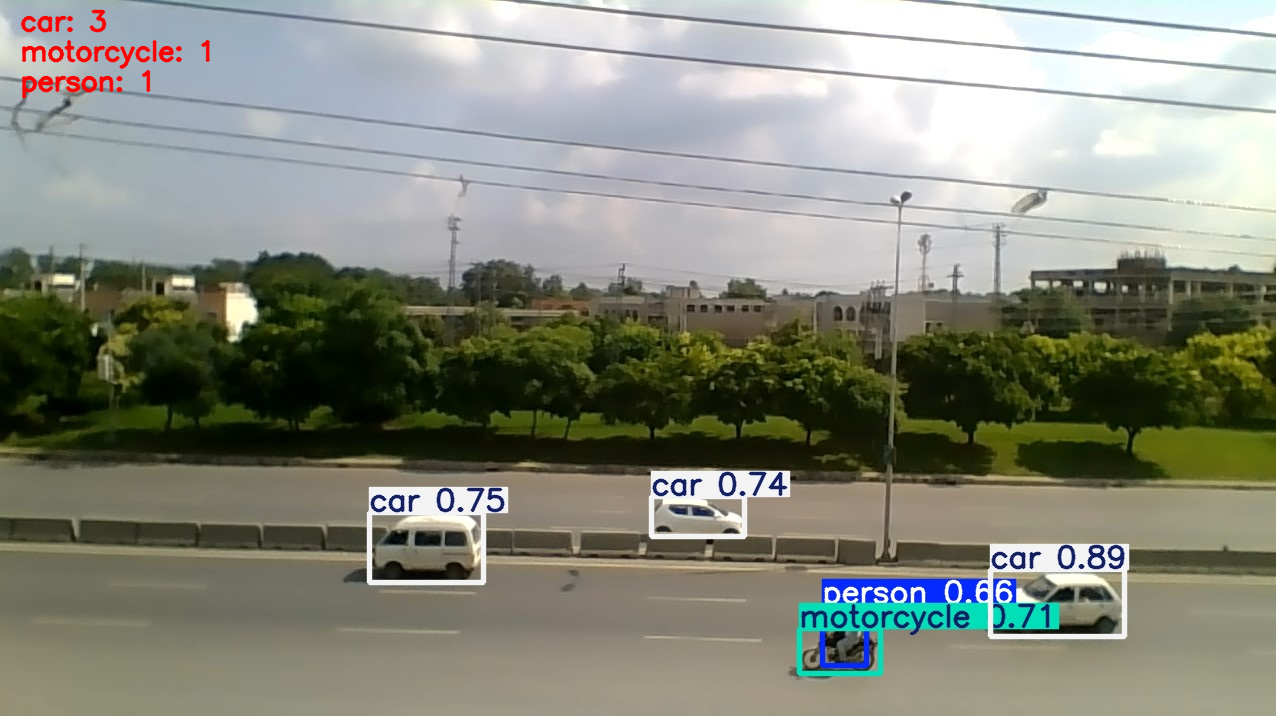


image 1/1 /content/Car Detection Media/Picture 2.jpg: 384x640 3 persons, 3 cars, 5 motorcycles, 1 truck, 25.3ms
Speed: 2.9ms preprocess, 25.3ms inference, 2.1ms postprocess per image at shape (1, 3, 384, 640)
Results saved to runs/detect/predict4


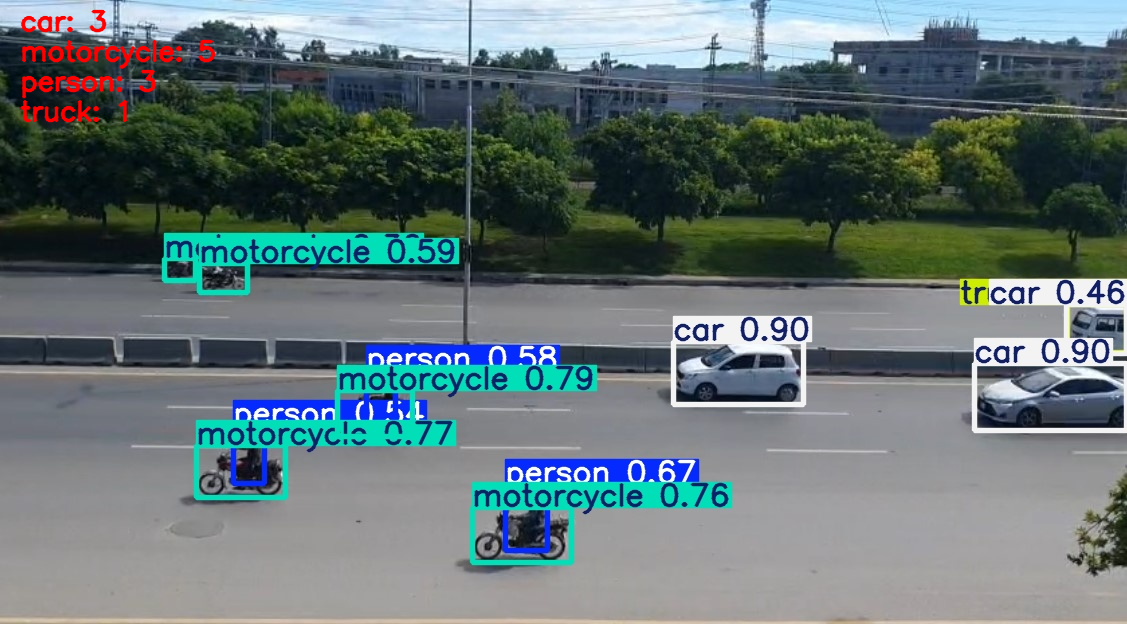


image 1/1 /content/Car Detection Media/Picture 3.jpg: 384x640 3 persons, 2 cars, 2 motorcycles, 25.3ms
Speed: 2.8ms preprocess, 25.3ms inference, 1.9ms postprocess per image at shape (1, 3, 384, 640)
Results saved to runs/detect/predict4


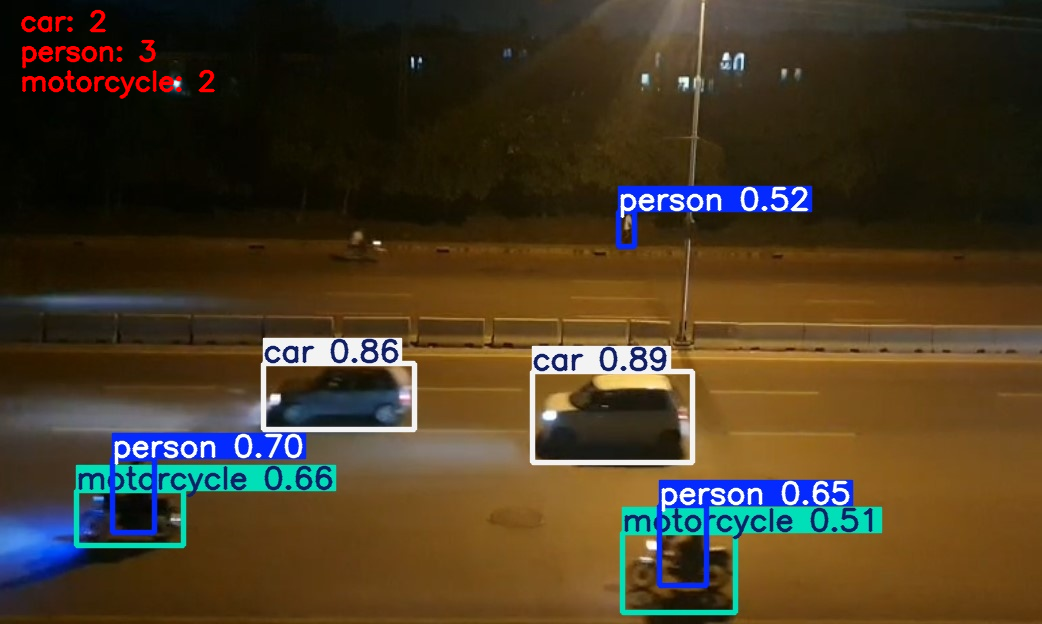

In [8]:
# Loop through Images, Detect Objects, Count & Show
for img_file in image_files:
    img_path = os.path.join(media_path, img_file)
    results = model.predict(source=img_path, save=True)

    # Load Detected Image
    pred_folder = results[0].save_dir
    detected_img = os.path.join(pred_folder, img_file)
    img = cv2.imread(detected_img)

    # Count Detected Objects
    names = model.names
    counts = {}
    for box in results[0].boxes:
        cls_id = int(box.cls)
        label = names[cls_id]
        counts[label] = counts.get(label, 0) + 1

    # Display Counts on Image
    y_offset = 30
    for label, count in counts.items():
        text = f"{label}: {count}"
        cv2.putText(img, text, (20, y_offset), cv2.FONT_HERSHEY_SIMPLEX,
                    0.9, (0, 0, 255), 2, cv2.LINE_AA)
        y_offset += 30

    # Show Image with Counts
    cv2_imshow(img)

# Car and Bike Detection on Video

## Car & Motorcycle Detection and Counting in Video

This cell runs the full video detection workflow:

1. Loads YOLOv8 model.
2. Tracks all objects in the video (cars, motorcycles, trucks, buses, etc.).
3. Draws bounding boxes on all detected objects.
4. Counts **only cars and motorcycles** as they cross the counting line (each counted once).
5. Saves the output video as `Car Detection Output.mp4` and makes it available for download.

> **Note:** This single cell ensures the output video is fully written before downloading.


In [9]:
from ultralytics import YOLO
import cv2
import numpy as np
from collections import defaultdict
from google.colab import files

video_path = "Car Detection Media/Day Video 1.mp4"
output_video = "Car Detection Output_HD.mp4"
tracker_cfg = "bytetrack.yaml"
COUNT_CLASSES = {"car", "motorcycle"}

model = YOLO("yolov8m.pt")
names = model.names

cap = cv2.VideoCapture(video_path)
fps = cap.get(cv2.CAP_PROP_FPS) or 30
w = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
h = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
cap.release()

line_x = int(w * 0.45)  # counting line

unique_ids = defaultdict(set)
total_counts = defaultdict(int)
id_last_pos = {}
writer = None

# process video
results_stream = model.track(
    source=video_path,
    tracker=tracker_cfg,
    persist=True,
    conf=0.25,
    stream=True,
    verbose=False
)

for res in results_stream:
    frame = res.plot()

    if res.boxes is not None and res.boxes.id is not None:
        ids  = res.boxes.id.int().cpu().tolist()
        clss = res.boxes.cls.int().cpu().tolist()
        xyxy = res.boxes.xyxy.cpu().numpy()

        for obj_id, cls_id, box in zip(ids, clss, xyxy):
            label = names[int(cls_id)]
            if label == "motorbike":
                label = "motorcycle"

            x1, y1, x2, y2 = map(int, box)
            cx = int((x1 + x2) / 2)

            cv2.circle(frame, (cx, int((y1+y2)/2)), 4, (0, 0, 255), -1)

            # count only cars & motorcycles
            if label in COUNT_CLASSES:
                prev_cx = id_last_pos.get(obj_id)
                if prev_cx is not None:
                    if prev_cx < line_x <= cx or prev_cx > line_x >= cx:
                        if obj_id not in unique_ids[label]:
                            total_counts[label] += 1
                            unique_ids[label].add(obj_id)
                id_last_pos[obj_id] = cx

    cv2.line(frame, (line_x, 0), (line_x, h), (255, 0, 0), 2)
    y = 35
    for lbl in COUNT_CLASSES:
        cv2.putText(frame, f"{lbl}: {total_counts[lbl]}", (20, y),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.9, (0, 0, 255), 2)
        y += 30

    if writer is None:
        writer = cv2.VideoWriter(output_video, cv2.VideoWriter_fourcc(*"mp4v"), fps, (w, h))
    writer.write(frame)

if writer:
    writer.release()

print("Saved:", output_video)
print("Final Counts:", dict(total_counts))

files.download(output_video)


Saved: Car Detection Output_HD.mp4
Final Counts: {'motorcycle': 7, 'car': 34}


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## Split Version of Video Detection

We divide the workflow into smaller steps for clarity:

1. **Initialize video & model** – Load the YOLOv8 model and get video properties.
2. **Set up counting logic** – Define line position, counters, and ID tracking.
3. **Process frames** – Track objects, draw bounding boxes, and count cars/motorcycles.
4. **Save and download output** – Release the VideoWriter and download the final video.

> **Important:** The video must be fully written (`writer.release()`) before downloading, otherwise the output may be empty.


## Importing the required libraries

In [10]:
!pip install -q ultralytics

from ultralytics import YOLO
import cv2
import numpy as np
from collections import defaultdict

## Video path and Model Setting

In [11]:
video_path = "Car Detection Media/Day Video 1.mp4"
model_path = "yolov8m.pt"
tracker_cfg = "bytetrack.yaml"

COUNT_CLASSES = {"car", "motorcycle"}

## Load the model

In [12]:
model = YOLO(model_path)

## Getting Video Info

In [13]:
cap = cv2.VideoCapture(video_path)
fps = cap.get(cv2.CAP_PROP_FPS) or 30
w = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
h = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
cap.release()

## Counting line at the little left from the middle

In [14]:
line_x = int(w * 0.45)

## Intialize Containers

In [15]:
unique_ids = defaultdict(set)
total_counts = defaultdict(int)
id_last_pos = {}

names = model.names
writer = None

## Start Tracking Stream

In [16]:
results_stream = model.track(
    source=video_path,
    tracker=tracker_cfg,
    persist=True,
    conf=0.25,
    classes=[2,3,5,7],
    stream=True,
    verbose=False
)

## Processing each frame

In [17]:
for res in results_stream:
    frame = res.plot()

## Ectracting IDs, Classes and Boxes

In [18]:
    if res.boxes is not None and res.boxes.id is not None:
        ids  = res.boxes.id.int().cpu().tolist()
        clss = res.boxes.cls.int().cpu().tolist()
        xyxy = res.boxes.xyxy.cpu().numpy()

## Counting the objects Crossing the line

In [19]:
        for obj_id, cls_id, box in zip(ids, clss, xyxy):
            label = names[int(cls_id)]
            if label == "motorbike":
                label = "motorcycle"
            if label not in COUNT_CLASSES:
                continue

            x1,y1,x2,y2 = box
            cx = int((x1+x2)/2)
            cy = int((y1+y2)/2)

            cv2.circle(frame, (cx, cy), 4, (0,0,255), -1)

            prev_cx = id_last_pos.get(obj_id, None)
            if prev_cx is not None:
                if prev_cx < line_x and cx >= line_x:
                    if obj_id not in unique_ids[label]:
                        total_counts[label] += 1
                        unique_ids[label].add(obj_id)
                elif prev_cx > line_x and cx <= line_x:
                    if obj_id not in unique_ids[label]:
                        total_counts[label] += 1
                        unique_ids[label].add(obj_id)

            id_last_pos[obj_id] = cx

## Draw Line & Overlay Counts

In [20]:
    cv2.line(frame, (line_x, 0), (line_x, h), (255,0,0), 2)
    y = 35
    for lbl in COUNT_CLASSES:
        cv2.putText(frame, f"{lbl}: {total_counts[lbl]}",
                    (20, y), cv2.FONT_HERSHEY_SIMPLEX, 0.9, (0,0,255), 2)
        y += 30

## Write Frame to Output Video

In [21]:
    if writer is None:
        writer = cv2.VideoWriter("Car Detection Output.mp4",
                                 cv2.VideoWriter_fourcc(*"mp4v"),
                                 fps, (w,h))
    writer.write(frame)

In [22]:
if writer:
    writer.release()

print("Saved:", "Car Detection Output.mp4")
print("Final Counts:", dict(total_counts))

Saved: Car Detection Output.mp4
Final Counts: {'motorcycle': 0, 'car': 0}


## Download the output

In [23]:
from google.colab import files
files.download("Car Detection Output.mp4")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## Running YOLOv8 on Live Webcam

This code can also be used to run live detection directly from the laptop's webcam.  
Unfortunately:
- Google Colab does not allow direct webcam access for security reasons.  
- On my local Jupyter Notebook, my CPU struggles to run YOLOv8m smoothly.  
- Using the smaller YOLOv8n model runs, but sometimes misses motorcycles.  

Below is the full code for running YOLOv8 on a live webcam (works on local Jupyter Notebook if you have GPU support).


In [24]:
from ultralytics import YOLO
import cv2
import numpy as np
from collections import defaultdict

# load YOLOv8 model
model = YOLO("yolov8m.pt")  # use "yolov8n.pt" if your PC is weak
names = model.names
COUNT_CLASSES = {"car", "motorcycle"}

cap = cv2.VideoCapture(0)  # 0 = default laptop webcam
if not cap.isOpened():
    print("❌ Could not open webcam")
    exit()

w = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
h = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))

line_x = int(w * 0.45)  # counting line
unique_ids = defaultdict(set)
total_counts = defaultdict(int)
id_last_pos = {}

print("✅ Press 'q' to quit the webcam window")

while True:
    ret, frame = cap.read()
    if not ret:
        break

    results = model.track(frame, tracker="bytetrack.yaml", persist=True, conf=0.25, verbose=False)

    frame = results[0].plot()
    if results[0].boxes is not None and results[0].boxes.id is not None:
        ids  = results[0].boxes.id.int().cpu().tolist()
        clss = results[0].boxes.cls.int().cpu().tolist()
        xyxy = results[0].boxes.xyxy.cpu().numpy()

        for obj_id, cls_id, box in zip(ids, clss, xyxy):
            label = names[int(cls_id)]
            if label == "motorbike":
                label = "motorcycle"

            x1, y1, x2, y2 = map(int, box)
            cx = int((x1 + x2) / 2)

            # track & count
            if label in COUNT_CLASSES:
                prev_cx = id_last_pos.get(obj_id)
                if prev_cx is not None:
                    if prev_cx < line_x <= cx or prev_cx > line_x >= cx:
                        if obj_id not in unique_ids[label]:
                            total_counts[label] += 1
                            unique_ids[label].add(obj_id)
                id_last_pos[obj_id] = cx

    cv2.line(frame, (line_x, 0), (line_x, h), (255, 0, 0), 2)
    y = 35
    for lbl in COUNT_CLASSES:
        cv2.putText(frame, f"{lbl}: {total_counts[lbl]}", (20, y),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.9, (0, 0, 255), 2)
        y += 30

    cv2.imshow("Live Webcam Detection", frame)
    if cv2.waitKey(1) & 0xFF == ord("q"):
        break

cap.release()
cv2.destroyAllWindows()
print("Final Counts:", dict(total_counts))


❌ Could not open webcam
✅ Press 'q' to quit the webcam window
Final Counts: {}
